In [1]:
# Get COVID-19 tweets
import pandas as pd
from os import listdir
from os.path import isfile, join

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
data.lang.unique()

array(['en'], dtype=object)

In [5]:
data.shape

(3407969, 5)

# Create emotion words data

In [6]:
emo_lex = pd.read_csv('/home/assem/Training data/Emotion_lexicon/NRC-Emotion-Intensity-Lexicon-v1.txt',sep="\t")

In [7]:
emo_lex.head()

,word,emotion,emotion-intensity-score
0,outraged,anger,0.964
1,brutality,anger,0.959
2,hatred,anger,0.953
3,hateful,anger,0.940
4,terrorize,anger,0.939


In [8]:
import numpy as np
emo_lex = emo_lex.set_index(['word','emotion'])['emotion-intensity-score']\
  .unstack()\
  .rename_axis([None], axis=1)\
  .reset_index()\
  .replace(np.nan, 0)

In [9]:
emo_lex.max()

word             zest
anger           0.964
anticipation    0.859
disgust         0.953
fear            0.984
joy             0.986
sadness         0.969
surprise         0.93
trust           0.906
dtype: object

In [10]:
emo_hash = pd.read_csv('/home/assem/Training data/Hashtag_lexicon/NRC-Hashtag-Emotion-Lexicon-v0.2.txt',sep="\t",names=['emotion','word','score'])


In [11]:
emo_hash.count()

emotion    32389
word       32385
score      32389
dtype: int64

In [12]:
emo_hash = emo_hash.set_index(['word','emotion'])['score']\
  .unstack()\
  .rename_axis([None], axis=1)\
  .reset_index()\
  .replace(np.nan, 0)

In [13]:
# Select only hashtags
emo_hash = emo_hash[emo_hash['word'].apply(lambda x: str(x).startswith('#'))]

In [14]:
emo_hash.max()

word            #zombies
anger            1.42992
anticipation     2.23748
disgust          1.73567
fear             1.95195
joy              2.16828
sadness          2.22058
surprise         1.48525
trust            2.68913
dtype: object

# Preprocess

In [15]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
#    removed "hashtag",
    annotate={ "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=False,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True,hashtags=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

Reading twitter - 1grams ...


/home/assem/.local/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))
/home/assem/.local/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [16]:
import re

def preprocess_tweets(text):
    result = " ".join(text_processor.pre_process_doc(text))
    result = re.sub(r'<elongated>', '', result)
    result = re.sub(r'<url>', '', result)
    result = re.sub(r'<user>', '', result)
#     result = re.sub(r'<hashtag> .+? </hashtag> ', '', result)
    result = result.replace('<','')
    result = result.replace('>','')
    return result

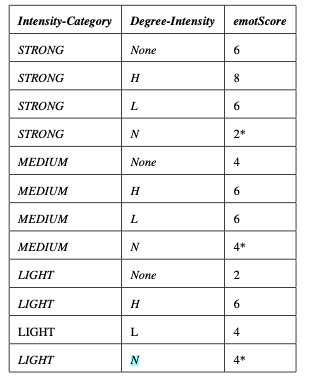

In [17]:
preprocess_tweets('@Dana, you are so loooovely :). https://journals.sagepub #cute')

' , you are so lovely  happy .  #cute'

https://onlineteachersuk.com/adverbs-of-degree/

In [18]:
degree_set = { 'little': 1,
                'bit':1,
                'slightly':1,
                'fairly':2,
                'pretty':2,
                'quite':2,
                'rather':2,
                'somewhat':2,
                'remarkably':3,
                'awfully':3,
                'extremely':3,
                'highly':3,
                'terribly':3,
                'lot':3,
                'really':3,
                'incredibly':3,
                'particularly':3,
                'deeply':3,
                'enormously':3,
                'greatly':3,
                'incredibly':3,
                'lots':3,
                'most':3,
                'remarkably':3,
                'strongly':3,
                'very':3,
                'totally':4,
                'utterly':4,
                'completely':4,
                'absolutely':4,
                'entirely':4,
                'perfectly':4,
                'thoroughly':4,
                'too':4,
}

In [19]:
import spacy
from spacy.tokenizer import _get_regex_pattern


nlp = spacy.load("en_core_web_sm")

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add your patterns (here: hashtags and in-word hyphens)
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match


def hit(text):
    doc = nlp(preprocess_tweets(text))
    hits = []
#     Detect the NSUBJ person
    person = 1
    for token in doc:
        if token.dep_ == 'nsubj':
            if str(token) in ['i', 'me', 'my', 'mine', 'myself']:
                person = 1
            elif str(token) in ['you', 'your', 'yours', 'yourself', 'yourselves']:
                person = 2
            elif str(token) in ['he', 'him', 'his', 'himself', 'she', 'her', \
                                  'hers', 'herself', 'it', 'its', 'itself', 'they',\
                                  'them', 'their', 'theirs', 'themselves']:
                person = 3
            elif token.pos_ == 'PROPN':
                person = 3

    for token in doc:  
        if token.lemma_ in list(emo_lex.word):
            row = emo_lex[emo_lex.word==token.lemma_]
            neg = False
            deg = 0
            for child in token.children:
                if child.lemma_ in degree_set.keys():
                    deg = degree_set[child.lemma_]
            for child in token.head.children:
                if child.dep_ == 'neg':
                    neg = True
                elif child.dep_ == 'advmod':
#                     print(child)
                    for grandchild in child.children:
                        if grandchild.dep_ == 'neg':
#                             print('Negative:',token.lemma_)
                            neg = True
            hits.append({'type': 'word', 'lemma' : token.lemma_, 'person': person,'scores': np.array(row.drop('word',axis=1).iloc[0].tolist()), 'neg':neg, 'deg':deg})
#         Consider emotional hashtags
        elif token.lemma_ in list(emo_hash.word):
            row = emo_hash[emo_hash.word==token.lemma_]
            hits.append({'type': 'hashtag','lemma' : token.lemma_, 'person': person, 'scores': np.array(row.drop('word',axis=1).iloc[0].tolist())})


   
    total_score = np.array([0]*8).astype('float64')
#     'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'
    for i in hits: 
#         print(i)
        score = np.array([0]*8).astype('float64')
        if i['type'] == 'word':
            if i['neg']:
#                 Handle the negation by Plutchik's wheel of emotions
                score[0] = i['scores'][3] #anger
                score[0] = 0
                score[1] = i['scores'][6] #anticipation
                score[2] = i['scores'][7] #disgust
                score[3] = i['scores'][0] #fear
                score[3] = 0
                score[4] = i['scores'][5] #joy
                score[5] = i['scores'][4] #sadness
                score[6] = i['scores'][1] #surprize
                score[7] = i['scores'][2] #trust
                score[score>0.66]-=0.33
                score[score<0.32]+=0.33
            else:
#                 Add weight to this word by degree presence
                score = i['scores']+ 0.1*deg
        elif i['type'] == 'hashtag':
            score = i['scores']*1.5
        
#         From paper: increase the weight of the first and second person
        if i['person']==1:
            score*=10
        elif i['person']==2:
            score*=2
        
#         Add to the final total score
        total_score += score
#         Normalize to see the proportion of each emotion
    if sum(total_score) !=0:
        total_score = total_score/sum(total_score)
    return total_score


# Example and Evaluation of NLP model

In [23]:
gold = pd.read_csv('/home/assem/Testing data/test_data.csv')
gold.head()

,Unnamed: 0,id,date,text,retweet_count,lang,subjectivity,preprocessed_text,label
0,0,1251133469444526080,Fri Apr 17 13:00:38 +0000 2020,My daugther (Emily) is turning 10 on Wednesday...,5.0,en,0.687500,my daugther ( emily ) is turning <number> on w...,joy
1,1,1251842259785564162,Sun Apr 19 11:57:07 +0000 2020,My Cat Scratched me Right When I Was Taking Th...,0.0,en,0.611905,my cat scratched me right when i was taking th...,joy
2,2,1246411656088993794,Sat Apr 04 12:17:50 +0000 2020,Like #colourful ballons drifting in the sky ou...,0.0,en,0.766667,like #colourful ballons drifting in the sky ou...,joy
3,3,1252078175544176640,Mon Apr 20 03:34:34 +0000 2020,We should let all these racist trumpies keep p...,0.0,en,1.000000,we should let all these racist trumpies keep p...,joy
4,4,1252382768857673731,Mon Apr 20 23:44:54 +0000 2020,This pandemic is going to make it reallyyyy ha...,1.0,en,0.558333,this pandemic is going to make it really hard...,joy


In [89]:
gold.groupby('label').count()

,Unnamed: 0,id,date,text,retweet_count,lang,subjectivity,preprocessed_text
label,,,,,,,,
anger,518,518,518,518,518,518,518,518
anticipation,431,431,431,431,431,431,431,431
disgust,58,58,58,58,58,58,58,58
fear,157,157,157,157,157,157,157,157
joy,3989,3989,3989,3989,3989,3989,3989,3989
sadness,2516,2516,2516,2516,2516,2516,2516,2516
surprise,68,68,68,68,68,68,68,68
trust,116,116,116,116,116,116,116,116


In [99]:
all_categories = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
labels = pd.get_dummies(gold.label).reindex(columns=all_categories, fill_value=0)
ans= np.array(labels)
tweets = np.array(gold['text'])
output = np.array(list(map(hit, tweets)))
     

In [100]:
check = output.copy()

# for i in range(len(check)):
#     check[i] = check[i] * (check[i] >= np.sort(check[i])[-sum(ans[i])]).astype(int)
    
# check[check>=1/8] = 1
# check[check<1/8] = 0

for row in check:
    if sum(row) != 0:
        row[row == max(row)] = 1
        row[row != max(row)] = 0

In [102]:
check


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [103]:
from sklearn.metrics import classification_report
print(classification_report(ans,check))
print(all_categories)

              precision    recall  f1-score   support

           0       0.78      0.36      0.50       518
           1       0.03      0.03      0.03       431
           2       0.35      0.83      0.49        58
           3       0.20      0.54      0.29       157
           4       0.81      0.62      0.70      3989
           5       0.92      0.74      0.82      2516
           6       0.42      0.62      0.50        68
           7       0.06      0.67      0.10       116

   micro avg       0.61      0.61      0.61      7853
   macro avg       0.45      0.55      0.43      7853
weighted avg       0.77      0.61      0.67      7853
 samples avg       0.61      0.61      0.61      7853

['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [20]:
gold = pd.read_csv('/home/assem/SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-train.txt', sep='\t')

In [21]:
gold = gold.drop(['love','optimism','pessimism'],axis=1)

In [22]:
ans= np.array(gold[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']])
ans

array([[0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [44]:
tweets = np.array(gold['Tweet'])
tweets

array(["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
       'Whatever you decide to do make sure it makes you #happy.',
       "@Max_Kellerman  it also helps that the majority of NFL coaching is inept. Some of Bill O'Brien's play calling was wow, ! #GOPATS",
       ...,
       "@isthataspider @dhodgs i will fight this guy! Don't insult the lions like that! But seriously they kinda are.Wasted some of the best players",
       'i wonder how a guy can broke his penis while having sex? #serious',
       "I'm highly animated even though I'm decomposing."], dtype=object)

In [45]:
output = np.array(list(map(hit, tweets)))
output

array([[0.00000000e+00, 3.87626942e-02, 0.00000000e+00, ...,
        1.75152161e-01, 1.87160439e-04, 2.63427847e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.59517766e-01, 0.00000000e+00, 2.23350254e-01, ...,
        0.00000000e+00, 0.00000000e+00, 3.42005076e-01],
       ...,
       [1.27780453e-01, 1.20558498e-01, 1.30476649e-01, ...,
        9.70630717e-02, 8.46413096e-02, 1.75637939e-01],
       [1.81798909e-01, 1.51923526e-01, 0.00000000e+00, ...,
        1.05799981e-01, 1.14325186e-01, 8.19731256e-02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [46]:
1/8

0.125

In [47]:
check = output.copy()

# for i in range(len(check)):
#     check[i] = check[i] * (check[i] >= np.sort(check[i])[-sum(ans[i])]).astype(int)
    
check[check>=1/8] = 1
check[check<1/8] = 0

# for row in check:
#     if sum(row) != 0:
#         row[row == max(row)] = 1
#         row[row != max(row)] = 0
    
 


In [48]:
check[np.isnan(check)]

array([], dtype=float64)

In [49]:
check[:10]

array([[0., 0., 0., 1., 1., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1., 1.],
       [1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0.]])

In [39]:
from sklearn.metrics import classification_report
print(classification_report(ans,check))
# 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'

              precision    recall  f1-score   support

           0       0.67      0.56      0.61      2544
           1       0.18      0.39      0.24       978
           2       0.68      0.41      0.51      2602
           3       0.39      0.81      0.52      1242
           4       0.60      0.70      0.64      2477
           5       0.49      0.58      0.53      2008
           6       0.12      0.40      0.19       361
           7       0.09      0.65      0.16       357

   micro avg       0.41      0.57      0.48     12569
   macro avg       0.40      0.56      0.43     12569
weighted avg       0.53      0.57      0.52     12569
 samples avg       0.42      0.58      0.45     12569



In [50]:
from sklearn.metrics import classification_report
print(classification_report(ans,check))
# 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'

              precision    recall  f1-score   support

           0       0.67      0.57      0.61      2544
           1       0.17      0.40      0.24       978
           2       0.68      0.41      0.51      2602
           3       0.39      0.81      0.52      1242
           4       0.59      0.70      0.64      2477
           5       0.49      0.59      0.53      2008
           6       0.12      0.40      0.19       361
           7       0.09      0.66      0.16       357

   micro avg       0.41      0.57      0.48     12569
   macro avg       0.40      0.57      0.43     12569
weighted avg       0.53      0.57      0.52     12569
 samples avg       0.41      0.59      0.45     12569



In [95]:
text = gold['Tweet'][4]
text

'#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse'

In [96]:
a = hit(text)
print(a)
# a = a * (a >= np.sort(a)[-3]).astype(int)
a[a>=0.15] = 1
a[a<0.15] = 0
a

[0.07245892 0.00750442 0.01989809 0.48725455 0.01507707 0.36822134
 0.00750442 0.0220812 ]


array([0., 0., 0., 1., 0., 1., 0., 0.])

'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'

# Create training data

In [49]:
data= data.drop_duplicates().sample(50000)

In [50]:
data['class']=data.text.apply(lambda x: hit(x))

In [51]:
data.isnull().mean()

id               0.0
date             0.0
text             0.0
retweet_count    0.0
lang             0.0
class            0.0
dtype: float64

In [52]:
data.head()

,id,date,text,retweet_count,lang,class
2458961,1241765178967879681,Sun Mar 22 16:34:24 +0000 2020,RT @yennikwok: Taiwan health officials said th...,4329,en,"[0.0, 0.23306451612903226, 0.0, 0.226612903225..."
2465546,1241758750412812289,Sun Mar 22 16:08:51 +0000 2020,RT @fema: ⚠ Due to the large amount of specula...,5437,en,"[0.0, 0.0, 0.0, 0.05858854860186419, 0.0, 0.08..."
3667753,1241749461065441282,Sun Mar 22 15:31:56 +0000 2020,RT @LindaKasonde: For Catholics who want to wa...,16,en,"[0.0, 0.32407407407407407, 0.0, 0.318518518518..."
2987373,1241711894378905602,Sun Mar 22 13:02:40 +0000 2020,RT @silv24: I volunteered to do this. The cons...,3020,en,"[0.0, 0.2944033302497687, 0.0, 0.0143385753931..."
2290313,1241687126166712320,Sun Mar 22 11:24:14 +0000 2020,RT @SaveOurSparrows: @Skyline73446331 My Windo...,2,en,"[0.0, 0.0, 0.0, 0.0, 0.619200734956362, 0.0863..."


In [53]:
def filter_tweets(label):
    if sum(label) != 0:
        new = [x>0.7 for x in label]
        i = iter(new)
        return any(i) and not any(i)
    return False

In [54]:
data['training'] = data['class'].apply(lambda x: filter_tweets(x))

In [55]:
data.groupby('training').count()

,id,date,text,retweet_count,lang,class
training,,,,,,
False,40632,40632,40632,40632,40632,40632
True,9368,9368,9368,9368,9368,9368


In [56]:
train_data = data[data.training]

In [57]:
train_data.shape

(9368, 7)

In [62]:
train_data[['id', 'date', 'text', 'retweet_count', 'lang', 'class','label']].to_csv('/home/assem/Training data/Trained_binary_v2/training_50.csv', index=False)

## Merge training data tables

In [60]:
data1 = pd.read_csv('/home/assem/Training data/Trained_binary_v2/training_0.csv')
data2 = pd.read_csv('/home/assem/Training data/Trained_binary_v2/training_10.csv')
data3 = pd.read_csv('/home/assem/Training data/Trained_binary_v2/training_20.csv')
data4 = pd.read_csv('/home/assem/Training data/Trained_binary_v2/training_30.csv')
data5 = pd.read_csv('/home/assem/Training data/Trained_binary_v2/training_40.csv')
data6 = pd.read_csv('/home/assem/Training data/Trained_binary_v2/training_50.csv')
data7 = pd.read_csv('/home/assem/Training data/Trained_binary_v2/training_60.csv')
data8 = pd.read_csv('/home/assem/Training data/Trained_binary_v2/training_70.csv')
data9 = pd.read_csv('/home/assem/Training data/Trained_binary_v2/training_80.csv')

In [61]:
frames = [data1, data2, data3,data4,data5,data6,data7,data8,data9]
train_data = pd.concat(frames)

In [62]:
train_data['class'] = train_data['class'].astype(str)

In [63]:
train_data.head()['class'][4]

'[0.         0.         0.         0.         0.17235189 0.\n 0.         0.82764811]'

In [64]:
from ast import literal_eval
train_data['class'] = train_data['class'].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))

In [65]:
 def label(class_list):
    for i, e in enumerate(class_list):
        if e == max(class_list):
            if i == 0:
                return 'anger'
            elif i == 1:
                return 'anticipation'
            elif i == 2:
                return 'disgust'
            elif i == 3:
                return 'fear'
            elif i == 4:
                return 'joy'
            elif i == 5:
                return 'sadness'
            elif i == 6:
                return 'surprise'
            elif i == 7:
                return 'trust'

In [66]:
train_data['label'] = train_data['class'].apply(lambda x: label(x))

In [67]:
train_data.groupby('label').count()

,id,date,text,retweet_count,lang,class
label,,,,,,
anger,2256,2256,2256,2256,2256,2256
anticipation,9257,9257,9257,9257,9257,9257
disgust,3755,3755,3755,3755,3755,3755
fear,14241,14241,14241,14241,14241,14241
joy,13368,13368,13368,13368,13368,13368
sadness,11656,11656,11656,11656,11656,11656
surprise,2854,2854,2854,2854,2854,2854
trust,26563,26563,26563,26563,26563,26563


In [68]:
train_data.groupby('label').apply(lambda x: x.sample(2256)).reset_index(drop=True)

,id,date,text,retweet_count,lang,class,label
0,1223635894629855233,Sat Feb 01 15:55:05 +0000 2020,RT @ezracheungtoto: US denies entry to all tho...,1349,en,"[0.70873786, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2...",anger
1,1245935880243535874,Fri Apr 03 04:47:16 +0000 2020,"RT @DailyMailUK: Over 1,500 ventilators could ...",9,en,"[0.77444444, 0.0, 0.0, 0.22555556, 0.0, 0.0, 0...",anger
2,1227255974450356229,Tue Feb 11 15:40:00 +0000 2020,Coronavirus to hit companies and consumers aro...,0,en,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",anger
3,1223703956930433025,Sat Feb 01 20:25:33 +0000 2020,RT @ezracheungtoto: US denies entry to all tho...,1349,en,"[0.70873786, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2...",anger
4,1230662859480236032,Fri Feb 21 01:17:44 +0000 2020,RT @RonaldKlain: Is anyone in charge of this r...,1237,en,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",anger
...,...,...,...,...,...,...,...
18043,1249708335512903681,Mon Apr 13 14:37:40 +0000 2020,RT @Jeffers28083958: If we are truly serious a...,72,en,"[0.0, 0.0, 0.0, 0.0, 0.28571429, 0.0, 0.0, 0.7...",trust
18044,1241875255875883009,Sun Mar 22 23:51:48 +0000 2020,RT @rajeev_mp: The #CoronaVirus protectors 🙏🏻🙏...,2883,en,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",trust
18045,1241576941250990080,Sun Mar 22 04:06:24 +0000 2020,"RT @narendramodi: In a few minutes from now, t...",11777,en,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",trust
18046,1241558032615694337,Sun Mar 22 02:51:16 +0000 2020,"RT @AdiBacelar: After this is all over, please...",37589,en,"[0.0, 0.0, 0.0, 0.288, 0.0, 0.0, 0.0, 0.712]",trust


In [69]:
def new_label(probs):
    c = probs.copy()
    c[c>=0.7]=1
    c[c<0.7]=0
    return c
train_data['class'] = train_data['class'].map(lambda x: new_label(x))

In [70]:
train_data.head()

,id,date,text,retweet_count,lang,class,label
0,1223402111590981632,Sat Feb 01 00:26:07 +0000 2020,RT @marceldirsus: This is an absolute nightmar...,44,en,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",fear
1,1223597697766002690,Sat Feb 01 13:23:19 +0000 2020,RT @magister_ella: #OUSTLENI2020 is more proba...,104,en,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",surprise
2,1223563576536748032,Sat Feb 01 11:07:44 +0000 2020,RT @NetworksManager: Apparently this story is ...,91,en,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",trust
3,1223743319429259264,Sat Feb 01 23:01:58 +0000 2020,fuckfuckfuck there’s a suspected case of the c...,0,en,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",fear
4,1223607627172573184,Sat Feb 01 14:02:46 +0000 2020,"RT @KKMPutrajaya: Dear all, \n\nWe have create...",4315,en,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",trust


# Classifier

https://github.com/susanli2016/NLP-with-Python/blob/master/Text%20Classification%20model%20selection.ipynb

In [71]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from gensim.utils import simple_preprocess

In [72]:
STOPWORDS = set(stopwords.words('english'))

In [73]:
train_data['text'] = train_data['text'].apply(preprocess_tweets)

In [78]:
train_data.isnull().mean()

id               0.000000
date             0.000000
text             0.000000
retweet_count    0.000012
lang             0.000012
class            0.000000
label            0.000024
dtype: float64

In [79]:
train_data = train_data.dropna(subset=['label'])

In [80]:
X = train_data.text
y = train_data.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)


## Logistic regression¶


https://github.com/nkartik94/Multi-Label-Text-Classification/blob/master/Mark_6.ipynb

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/home/assem/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [83]:
%%time
from sklearn.metrics import classification_report
y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.936986301369863
              precision    recall  f1-score   support

       anger       0.89      0.82      0.85       694
anticipation       0.94      0.94      0.94      2828
     disgust       0.90      0.85      0.87      1103
        fear       0.92      0.92      0.92      4307
         joy       0.95      0.94      0.94      3976
     sadness       0.95      0.96      0.95      3504
    surprise       0.88      0.87      0.88       887
       trust       0.95      0.97      0.96      7886

    accuracy                           0.94     25185
   macro avg       0.92      0.91      0.91     25185
weighted avg       0.94      0.94      0.94     25185

CPU times: user 1.2 s, sys: 24 ms, total: 1.23 s
Wall time: 1.22 s


In [113]:
from sklearn.metrics import classification_report
gold['text']=gold['text'].apply(preprocess_tweets)
y_pred = logreg.predict(gold.text)

print('accuracy %s' % accuracy_score(y_pred, gold.label))
print(classification_report(gold.label, y_pred))

accuracy 0.5122882974659366
              precision    recall  f1-score   support

       anger       0.58      0.40      0.47       518
anticipation       0.05      0.06      0.06       431
     disgust       0.08      0.33      0.13        58
        fear       0.12      0.50      0.19       157
         joy       0.74      0.42      0.53      3989
     sadness       0.85      0.78      0.82      2516
    surprise       0.01      0.03      0.01        68
       trust       0.04      0.41      0.07       116

    accuracy                           0.51      7853
   macro avg       0.31      0.37      0.29      7853
weighted avg       0.69      0.51      0.57      7853



In [86]:
import pickle
# save the model to disk
filename = 'logreg_model.sav'
pickle.dump(logreg, open(filename, 'wb'))
 

# Combine NLP and Logistic regression

In [104]:
def CombinedModel(text):
    nlp_labels = hit(text)
    ml_labels = logreg.predict_proba([text])
    ml_labels[ml_labels==ml_labels.max()] = 1
    ml_labels[ml_labels!=ml_labels.max()] = 0
    combined_labels = ml_labels[0]*0.1 + nlp_labels
    combined_labels = combined_labels/sum(combined_labels)
    return combined_labels

In [278]:
CombinedModel(X_test[0])

array([1., 0., 0., 0., 0., 0., 0., 0.])

In [106]:
gold = pd.read_csv('/home/assem/Testing data/test_data.csv')
gold.head()

,Unnamed: 0,id,date,text,retweet_count,lang,subjectivity,preprocessed_text,label
0,0,1251133469444526080,Fri Apr 17 13:00:38 +0000 2020,My daugther (Emily) is turning 10 on Wednesday...,5.0,en,0.687500,my daugther ( emily ) is turning <number> on w...,joy
1,1,1251842259785564162,Sun Apr 19 11:57:07 +0000 2020,My Cat Scratched me Right When I Was Taking Th...,0.0,en,0.611905,my cat scratched me right when i was taking th...,joy
2,2,1246411656088993794,Sat Apr 04 12:17:50 +0000 2020,Like #colourful ballons drifting in the sky ou...,0.0,en,0.766667,like #colourful ballons drifting in the sky ou...,joy
3,3,1252078175544176640,Mon Apr 20 03:34:34 +0000 2020,We should let all these racist trumpies keep p...,0.0,en,1.000000,we should let all these racist trumpies keep p...,joy
4,4,1252382768857673731,Mon Apr 20 23:44:54 +0000 2020,This pandemic is going to make it reallyyyy ha...,1.0,en,0.558333,this pandemic is going to make it really hard...,joy


In [107]:
gold.groupby('label').count()

,Unnamed: 0,id,date,text,retweet_count,lang,subjectivity,preprocessed_text
label,,,,,,,,
anger,518,518,518,518,518,518,518,518
anticipation,431,431,431,431,431,431,431,431
disgust,58,58,58,58,58,58,58,58
fear,157,157,157,157,157,157,157,157
joy,3989,3989,3989,3989,3989,3989,3989,3989
sadness,2516,2516,2516,2516,2516,2516,2516,2516
surprise,68,68,68,68,68,68,68,68
trust,116,116,116,116,116,116,116,116


In [108]:
all_categories = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
labels = pd.get_dummies(gold.label).reindex(columns=all_categories, fill_value=0)
ans= np.array(labels)
tweets = np.array(gold['text'])
output = np.array(list(map(CombinedModel, tweets)))
     

In [109]:
check = output.copy()

# for i in range(len(check)):
#     check[i] = check[i] * (check[i] >= np.sort(check[i])[-sum(ans[i])]).astype(int)
    
# check[check>=1/8] = 1
# check[check<1/8] = 0

for row in check:
    if sum(row) != 0:
        row[row == max(row)] = 1
        row[row != max(row)] = 0

In [287]:
gold = pd.read_csv('/home/assem/SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-train.txt', sep='\t')

gold = gold.drop(['love','optimism','pessimism'],axis=1)

ans= np.array(gold[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']])

tweets = np.array(gold['Tweet'])


In [288]:
output = np.array(list(map(CombinedModel, tweets)))
output

array([[0.00000000e+00, 6.45041867e-03, 0.00000000e+00, ...,
        1.84181372e-01, 2.07633175e-04, 2.92243171e-01],
       [0.00000000e+00, 0.00000000e+00, 9.09090909e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.35925242e-01, 0.00000000e+00, 2.03045685e-01, ...,
        0.00000000e+00, 0.00000000e+00, 3.10913706e-01],
       ...,
       [1.16164048e-01, 1.09598634e-01, 1.18615135e-01, ...,
        8.82391561e-02, 7.69466451e-02, 2.50579945e-01],
       [5.42712503e-01, 6.80291189e-02, 0.00000000e+00, ...,
        4.73756742e-02, 1.42102226e-01, 3.67063591e-02],
       [9.09090909e-02, 0.00000000e+00, 9.09090909e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [289]:
tweets[0]

"“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry"

In [290]:
gold.head(1)

,ID,Tweet,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,2017-En-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,0,1


In [291]:
hit(tweets[0])

array([0.00000000e+00, 7.09546054e-03, 0.00000000e+00, 2.37552046e-01,
       3.31057099e-01, 1.02599509e-01, 2.28396493e-04, 3.21467488e-01])

In [292]:
logreg.predict_proba([tweets[0]])[0]

array([3.26683324e-05, 4.42378607e-14, 2.22985912e-09, 4.67007750e-12,
       1.73009050e-10, 9.99967323e-01, 4.05509838e-09, 2.01890223e-09])

In [293]:
CombinedModel(tweets[0])

array([0.00000000e+00, 6.45041867e-03, 0.00000000e+00, 2.15956406e-01,
       3.00960999e-01, 1.84181372e-01, 2.07633175e-04, 2.92243171e-01])

In [295]:
check = output.copy()
# for i in range(len(check)):
#     check[i] = check[i] * (check[i] >= np.sort(check[i])[-sum(ans[i])]).astype(int)
# check[check>0] = 1
from sklearn.metrics import jaccard_score
check[check>=0.125] = 1
check[check<0.125] = 0

# for row in check:
#     if sum(row) != 0:
#         row[row == max(row)] = 1
#         row[row != max(row)] = 0

check[np.isnan(check)]

from sklearn.metrics import classification_report
print(classification_report(ans,check))
# 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'
print(jaccard_score(ans,check, average='samples'))


              precision    recall  f1-score   support

           0       0.66      0.55      0.60      2544
           1       0.18      0.37      0.24       978
           2       0.65      0.40      0.50      2602
           3       0.39      0.79      0.52      1242
           4       0.60      0.69      0.64      2477
           5       0.49      0.57      0.53      2008
           6       0.12      0.40      0.19       361
           7       0.09      0.62      0.16       357

   micro avg       0.41      0.56      0.47     12569
   macro avg       0.40      0.55      0.42     12569
weighted avg       0.52      0.56      0.52     12569
 samples avg       0.45      0.57      0.46     12569

0.354344768032981


In [257]:
text = gold['Tweet'][4]
text



'#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse'

In [264]:
a = hit(text)
print(a)
a = a * (a >= np.sort(a)[-3]).astype(int)
a[a>0] = 1
a


[0.06772093 0.0039981  0.00873525 0.51250996 0.00803255 0.38324099
 0.0039981  0.01176412]


array([1., 0., 0., 1., 0., 1., 0., 0.])


'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'